In [51]:
# set-up ipython kernel
# python -m ipykernel install --name tfenv


import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import pandas as pd
import math
import matplotlib.pyplot as plt

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
!python --version

Python 3.9.13


In [6]:
tf.__version__

'2.10.1'

### *Import Data*

In [7]:
train_df = pd.read_csv('Train.csv')

test_df = pd.read_csv('Test.csv')

valid_df = pd.read_csv('Valid.csv')

In [8]:
train_df.shape

(40000, 2)

In [9]:
test_df.shape

(5000, 2)

In [10]:
valid_df.shape

(5000, 2)

In [11]:
train_df.head(3)

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0


## Download pre-trained BERT preprocessor and BERT Model (encoder)

Before training a model using BERT, the text data needs to be first converted into machine-readable tokens in the form of tensors. To achieve this, a preprocessing model specifically created for BERT is used to translate English words into numerical values, which will give N tensors (N being the training sample size), each with a fixed length of 128 (this is by default, we may change the input sequence length to up to 512 tokens at maximum). A pre-trained BERT model is then used to generate outputs based on those preprocessed input (tensors). In our case, 'cased' BERT model is used, because it can recognize upper-cased letters in the context, which may be related to excitement or intentional emphasis on a specific word.

In [40]:
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2", trainable=True, name="BERT_encoder")
bert_preprocess_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='Pre-Processing')


*Test the preprocessor*

+ We can test how the preprocessor essentially works using simple input texts.
+ There are 3 outputs, namely the word id, input mask indicator and type id.
+ The word id vector simply gives the corresponding id for each word that is recognizable by BERT.
+ The input mask tells which token is masked (0) and which is not (1). 
+ The type id has the index of the input segment that gave rise to the input token at the respective position. In this case, because we only have one input sentence, the type id is a zero vector.

In [41]:
def test_process_model(input_text):
  t = [input_text]
  processed_t = bert_preprocess_model(t)
  print(f'Original text: {input_text}')
  print(f'Shape: {processed_t["input_word_ids"].shape}')
  print(f'Word Id: {processed_t["input_word_ids"][0,:12]}')
  print(f'Input Mask Indicator: {processed_t["input_mask"][0,:12]}')
  print(f'Type Id: {processed_t["input_type_ids"][0, :12]}')
  return

test_process_model('This is really a wonderful movie!')
print()
test_process_model('I really don\'t like this movie')


Original text: This is really a wonderful movie!
Shape: (1, 128)
Word Id: [ 101 2023 2003 2428 1037 6919 3185  999  102    0    0    0]
Input Mask Indicator: [1 1 1 1 1 1 1 1 1 0 0 0]
Type Id: [0 0 0 0 0 0 0 0 0 0 0 0]

Original text: I really don't like this movie
Shape: (1, 128)
Word Id: [ 101 1045 2428 2123 1005 1056 2066 2023 3185  102    0    0]
Input Mask Indicator: [1 1 1 1 1 1 1 1 1 1 0 0]
Type Id: [0 0 0 0 0 0 0 0 0 0 0 0]


In [42]:
def test_bert_model(input_text, output=False):
  t = [input_text]
  processed_t = bert_preprocess_model(t)
  bert_results = bert_encoder(processed_t)

  if output is False:
      print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
      print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :5]}')
  if output is True:
      return bert_results["pooled_output"]


test_bert_model('This is really a wonderful movie!')

Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.24430047  0.99493533 -0.06289306  0.3481398   0.51652336]


In [43]:
from sklearn.metrics.pairwise import cosine_similarity


embedding_1 = test_bert_model("Elon Musk", True)
embedding_2 = test_bert_model("Jeff Bezos", True)
embedding_3 = test_bert_model("University of California, Davis", True)

print(cosine_similarity(embedding_1, embedding_2))
print(cosine_similarity(embedding_2, embedding_3))


[[0.8590814]]
[[0.6185554]]


# BERT model

### *Model Construction*

In [44]:
def build_classifier_model():

  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='Text')
  # preprocessing
  preprocessing_layer = bert_preprocess_model
  encoder_input = preprocessing_layer(text_input)
  # applying BERT
  encoder = bert_encoder
  outputs = encoder(encoder_input)

  net = outputs['pooled_output']
  # drop-out layer
  net = tf.keras.layers.Dropout(0.4, name='Drop-Out')(net)
  # applying sigmoid activation function
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='Classifier')(net)
  return tf.keras.Model(text_input, net)

### *Structure*

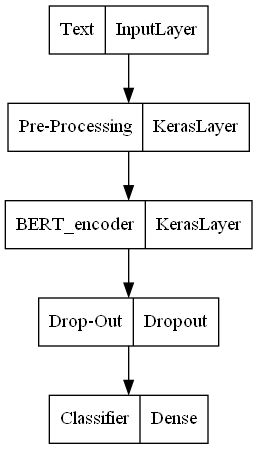

In [45]:
classifier_model = build_classifier_model()

tf.keras.utils.plot_model(classifier_model)

### *Compile & Train*



In [46]:
# metrics

metrics = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

# optimizer

epochs = 5
batch_size = 64
steps_per_epoch = len(train_df)/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

# loss
loss = tf.keras.losses.BinaryCrossentropy()


classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [47]:
train_X = train_df['text']
train_y = train_df['label']
valid_X = valid_df['text']
valid_y = valid_df['label']


model_history = classifier_model.fit(train_X, train_y, 
                                     validation_data = (valid_X, valid_y), epochs=epochs,
                                    batch_size=batch_size)

Epoch 1/5
625/625 [==============================] - 592s 939ms/step - loss: 0.5085 - accuracy: 0.7445 - precision: 0.7540 - recall: 0.7249 - val_loss: 0.3585 - val_accuracy: 0.8448 - val_precision: 0.8533 - val_recall: 0.8349
Epoch 2/5
625/625 [==============================] - 588s 940ms/step - loss: 0.3311 - accuracy: 0.8571 - precision: 0.8568 - recall: 0.8571 - val_loss: 0.3414 - val_accuracy: 0.8508 - val_precision: 0.8194 - val_recall: 0.9021
Epoch 3/5
625/625 [==============================] - 588s 942ms/step - loss: 0.2677 - accuracy: 0.8880 - precision: 0.8866 - recall: 0.8895 - val_loss: 0.3406 - val_accuracy: 0.8612 - val_precision: 0.8708 - val_recall: 0.8500
Epoch 4/5
625/625 [==============================] - 593s 948ms/step - loss: 0.2225 - accuracy: 0.9100 - precision: 0.9082 - recall: 0.9121 - val_loss: 0.3705 - val_accuracy: 0.8608 - val_precision: 0.8728 - val_recall: 0.8465
Epoch 5/5
625/625 [==============================] - 588s 941ms/step - loss: 0.1896 - accura

### *Model History*

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


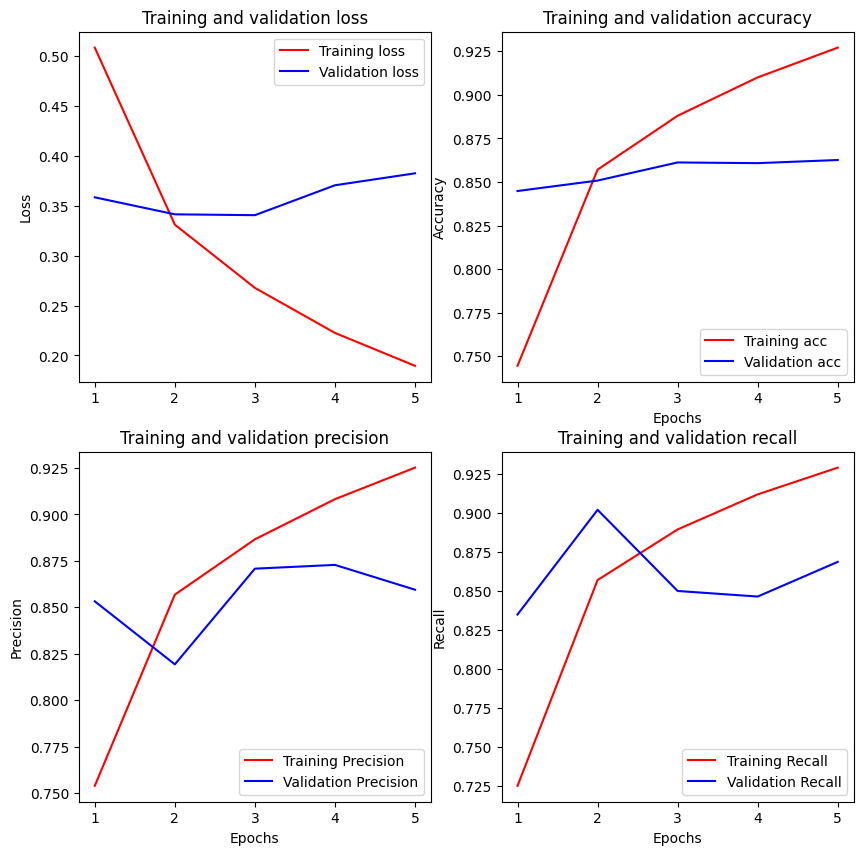

In [53]:
history_dict = model_history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

prec = history_dict['precision']
val_prec = history_dict['val_precision']

recall = history_dict['recall']
val_recall = history_dict['val_recall']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 10))
fig.tight_layout()

plt.subplot(2, 2, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(2, 2, 3)
plt.plot(epochs, prec, 'r', label='Training Precision')
plt.plot(epochs, val_prec, 'b', label='Validation Precision')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend(loc='lower right')

plt.subplot(2, 2, 4)
plt.plot(epochs, recall, 'r', label='Training Recall')
plt.plot(epochs, val_recall, 'b', label='Validation Recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend(loc='lower right')

### *Save Model*

In [55]:
classifier_model.save("./imdb_bert_model", include_optimizer=False)

INFO:tensorflow:Assets written to: ./imdb_bert_model\assets


INFO:tensorflow:Assets written to: ./imdb_bert_model\assets


### *Model Evaluation*

In [58]:
test_X = test_df['text']
test_y = test_df['label']

test_loss, test_acc, test_prec, test_recall = classifier_model.evaluate(test_X,test_y)


157/157 [==============================] - 31s 199ms/step - loss: 0.3610 - accuracy: 0.8728 - precision: 0.8649 - recall: 0.8842


In [61]:
print("The model achieved an accuracy of {0} with the testing set.".format(round(test_acc,2)))
print("The model achieved a precision of {0} with the testing set.".format(round(test_prec,2)))
print("The model achieved a recall of {0} with the testing set.".format(round(test_recall,2)))

The model achieved an accuracy of 0.87 with the testing set.
The model achieved a precision of 0.86 with the testing set.
The model achieved a recall of 0.88 with the testing set.


### *Experiment with Custom Text*

In [78]:
def get_score(text, model=classifier_model):
    score = model(tf.constant([text]))[0][0]
    print("Input text: {}".format(text))
    print()
    print("Score: {}".format(score))

#### Positive Feedback

In [94]:
get_score("The movie was really great!")

Input text: The movie was really great!

Score: 0.9963254332542419


In [83]:
get_score("This film was a piece of art!")

Input text: This film was a piece of art!

Score: 0.9968183040618896


#### Negative Feedback

In [82]:
get_score("I kinda hate the main character...")

Input text: I kinda hate the main character...

Score: 0.03626956790685654


In [81]:
get_score("The movie was terrible...")

Input text: The movie was terrible...

Score: 0.0014141895808279514
